# **Distinguishing lipoma from well-differentiated liposarcoma** 

# Set up

In [ ]:
#Use from colab environment
!git clone https://github.com/jveenland/tm10007_ml.git

#General installations
!pip install sklearn numpy matplotlib

#General packages
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import torch
import seaborn
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import VarianceThreshold
import warnings
warnings.filterwarnings("ignore")

Cloning into 'tm10007_ml'...
remote: Enumerating objects: 83, done.
remote: Total 83 (delta 0), reused 0 (delta 0), pack-reused 83
Unpacking objects: 100% (83/83), 67.99 MiB | 6.17 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# Data loading 

In [ ]:
data = pd.read_csv('/content/tm10007_ml/worclipo/Lipo_radiomicFeatures.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 115
The number of columns: 494


# Data cleaning
First, we'll check if there are any missing values in the dataset.


In [ ]:
#Check for missing values 
if data.isnull().values.any():
    print('There are missing values in the dataset')
else:
    print('There are no missing values in the dataset')

There are no missing values in the dataset


# Data splitting
The dataset will be split into a training, validation, and test set. The train+validation over test and train over validation ratio will both be 0.8/0.2.

In [ ]:
# Specify the features
x = data.iloc[:, 1:]

# Specify the target
y = data.iloc[:, 0]

# Split the data into training and testing sets
x_train_val, x1_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# Split the training set into training and validation sets
x1_train, x1_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=42, shuffle=True, stratify=y_train_val)

# Print the shapes of the subsets
print("Training set shape:", x1_train.shape, y_train.shape)
print("Validation set shape:", x1_val.shape, y_val.shape)
print("Testing set shape:", x1_test.shape, y_test.shape)

Training set shape: (73, 493) (73,)
Validation set shape: (19, 493) (19,)
Testing set shape: (23, 493) (23,)


# Check for zero values
We'll check wether any of the features contain objects with the value zero, to assess wether this is plausible or if it might mean the value's missing. 

In [ ]:
#Check for zero values
objects, features = np.where(x1_train == 0)

#Check which features contain zero values
features_zeros = set(features)
features_zeros = sorted(features_zeros)
print(f"The following columns contain zero values: {features_zeros}")

#Show which features contain zero values
column_names = x1_train.columns
features_zeros_names = [column_names[i] for i in features_zeros]
print(f"The following features contain zero values: {features_zeros_names}")

#Check and show how often a feature contains a zero value
zeros = {}
for column in features_zeros:
    zero_count = 0
    for feature in features:
        if feature == column:
            zero_count += 1
    zeros[column_names[column]] = zero_count
print(f"This dictionary shows the amount of zero values the features contain: {zeros}")

# Show features for which all values are zero
all_zeros = []
for feature, zerocount in zeros.items():
    if zerocount == len(x1_train):
        all_zeros.append(feature)
print(f"The following features contain only zero values: {all_zeros}")

x2_train = x1_train.drop(columns=all_zeros)
x2_val = x1_val.drop(columns=all_zeros)
x2_test = x1_test.drop(columns=all_zeros)

print("Training set shape:", x2_train.shape, y_train.shape)
print("Validation set shape:", x2_val.shape, y_val.shape)
print("Testing set shape:", x2_test.shape, y_test.shape)

The following columns contain zero values: [18, 76, 89, 100, 102, 113, 415, 418, 422, 423, 426, 428, 431, 435, 436, 439, 441, 444, 448, 449, 452, 454, 461, 462, 467, 470, 474, 475, 478, 480, 483, 487, 488, 491]
The following features contain zero values: ['PREDICT_original_sf_area_min_2.5D', 'PREDICT_original_tf_LBP_min_R3_P12', 'PREDICT_original_tf_LBP_min_R8_P24', 'PREDICT_original_tf_LBP_quartile_range_R8_P24', 'PREDICT_original_tf_LBP_min_R15_P36', 'PREDICT_original_tf_LBP_quartile_range_R15_P36', 'PREDICT_original_vf_Frangi_full_min_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_vf_Frangi_full_median_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_vf_Frangi_full_peak_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_vf_Frangi_full_peak_position_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_vf_Frangi_full_quartile_range_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_vf_Frangi_edge_min_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_vf_Frangi_edge_median_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_vf_Frangi_edge_peak_SR(1.0, 10.0)_

# Scale data

In [ ]:
# Scale the dataset 
scaler = StandardScaler()
scaler.fit(x2_train)

x3_train = scaler.transform(x2_train)
x3_val = scaler.transform(x2_val)
x3_test = scaler.transform(x2_test)

# Feature selection
The data set contains 493 classifiers and 115 objects, so the dimensionality is assumably too high for the amount of objects. In order to solve this, we will perform feature selection. Lasso regression will be used for this. 

In [ ]:
# Turn the labels into numbers (0 = lipoma, 1 = liposarcoma)
zero_ones = []

# Iterate over the values and encode them
for value in y_train:
    if value == 'lipoma':
        zero_ones.append(0)
    elif value == 'liposarcoma':
        zero_ones.append(1)

print(y_train)
print(zero_ones)

# define the parameter grid for alpha
alpha_grid = np.logspace(-5, 2, 10)

# create the outer CV loop for testing
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# create the nested CV loop for hyperparameter tuning
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# create the LassoCV model with the alpha parameter grid and the inner CV loop
lasso_cv = LassoCV(alphas=alpha_grid, cv=inner_cv)

# use GridSearchCV to tune the alpha parameter of the Lasso model with the outer CV loop
lasso_grid = GridSearchCV(estimator=lasso_cv, param_grid={'alphas': alpha_grid}, cv=outer_cv, scoring='neg_mean_squared_error')

# fit the Lasso model with the best alpha value on the entire training set
#lasso_grid.fit(x3_train, zero_ones)

# print the best alpha value
#print('Best alpha:', lasso_grid.best_estimator_.alpha_)

lasso_cv.fit(x3_train, zero_ones)
best_alpha = lasso_cv.alpha_
print("Best alpha:", best_alpha)

# Get the coefficients of the selected features
selected_features_mask = lasso_cv.coef_ != 0

# Create a new dataset containing only the selected features
x4_train = x3_train[:, selected_features_mask]
x4_val = x3_val[:, selected_features_mask]
x4_test = x3_test[:, selected_features_mask]
print(x4_train.shape)

ID
Lipo-089_0    liposarcoma
Lipo-086_0    liposarcoma
Lipo-060_0    liposarcoma
Lipo-103_0    liposarcoma
Lipo-052_0         lipoma
                 ...     
Lipo-008_0         lipoma
Lipo-054_0    liposarcoma
Lipo-100_0    liposarcoma
Lipo-076_0         lipoma
Lipo-066_0         lipoma
Name: label, Length: 73, dtype: object
[1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0]
Best alpha: 0.0774263682681127
(73, 7)


# Make labels binary

In [ ]:
# Turn the labels into numbers (0 = lipoma, 1 = liposarcoma)
zero_ones_train = []
zero_ones_val = []
zero_ones_test = []

# Iterate over the values and encode them
for value in y_train:
    if value == 'lipoma':
        zero_ones_train.append(0)
    elif value == 'liposarcoma':
        zero_ones_train.append(1)

for value in y_val:
    if value == 'lipoma':
        zero_ones_val.append(0)
    elif value == 'liposarcoma':
        zero_ones_val.append(1)

for value in y_test:
    if value == 'lipoma':
        zero_ones_test.append(0)
    elif value == 'liposarcoma':
        zero_ones_test.append(1)

print(zero_ones_train)
print(zero_ones_val)
print(zero_ones_test)

[1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0]
[1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0]
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0]


In [ ]:
y_train = zero_ones_train
y_val = zero_ones_val
y_test = zero_ones_test

# Classification
Now it is time to train a classifier on the trainingsdata set. Based on the cheatsheet from the sklearn package, we will start with linear SVC.

# Linear SVC

In [ ]:
# LinearSVC determine optimal C
C_range = [0.001, 0.01, 0.1, 1, 10, 100]

# Create an empty list to store the cross-validation scores
cv_scores = []

# Perform 5-fold cross-validation for each value of C
for C in C_range:
    svm = SVC(kernel='linear', C=C, max_iter=100000)
    scores = cross_val_score(svm, x4_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the optimal value of C that gives the highest cross-validation score
optimal_C = C_range[np.argmax(cv_scores)]
print("The optimal value of C is %0.3f" % optimal_C)


The optimal value of C is 0.100


# RBF SVC

In [ ]:
# RBFSVC determine optimal C
C_range = [0.001, 0.01, 0.1, 1, 10, 100]

# Create an empty list to store the cross-validation scores
cv_scores = []

# Perform 5-fold cross-validation for each value of C
for C in C_range:
    svm = SVC(kernel='rbf', C=C, max_iter=1000)
    scores = cross_val_score(svm, x4_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the optimal value of C that gives the highest cross-validation score
optimal_C1 = C_range[np.argmax(cv_scores)]
print("The optimal value of C is %0.3f" % optimal_C1)

The optimal value of C is 1.000


# kNN

In [ ]:
# kNN determine k
k_range = range(1, 31)

# Create an empty list to store the cross-validation scores
cv_scores = []

# Perform 5-fold cross-validation for each value of k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x4_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the optimal value of k that gives the highest cross-validation score
optimal_k = k_range[np.argmax(cv_scores)]
print("The optimal number of neighbors is %d" % optimal_k)

The optimal number of neighbors is 17


# Random forest

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20],
}

# Create a Random Forest classifier object
rfc = RandomForestClassifier(random_state=42)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(x4_train, y_train)

# Print the results of the grid search
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

max_depth = grid_search.best_params_['max_depth']
n_estimators = grid_search.best_params_['n_estimators']

Best parameters: {'max_depth': None, 'n_estimators': 100}
Best cross-validation score: 0.8095238095238095


# Multi-layer Perceptron (MLP)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=10000)

# Define the hyperparameters to tune
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (200,), (50, 50), (100, 100), (200, 200)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam']
}

# Tune the hyperparameters using a grid search with cross-validation
grid = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5)
grid.fit(x4_train, y_train)

# Print the best hyperparameters and their corresponding accuracy score
print("Best hyperparameters:", grid.best_params_)
print("Accuracy score:", grid.best_score_)

activation = grid.best_params_['activation']
hidden_layer_sizes = grid.best_params_['hidden_layer_sizes']
solver = grid.best_params_['solver']

Best hyperparameters: {'activation': 'logistic', 'hidden_layer_sizes': (50,), 'solver': 'sgd'}
Accuracy score: 0.8495238095238096


# Classifiers vergelijken
First an estimation which classifier would perform the best on our data is done by crossvalidation.

In [ ]:
# Define classifiers and parameters
clfs = {
    'SVC_linear': SVC(kernel='linear', C=optimal_C),
    'KNN': KNeighborsClassifier(n_neighbors=optimal_k),
    'SVC_rbf': SVC(kernel='rbf', C=optimal_C1),
    'RF': RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators),
    'MLP': MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver)
}

# Fit the classifiers to the training data
for name, clf in clfs.items():
    clf.fit(x4_train, y_train)

# Cross validate the classifiers
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']
cv_results = {}
for name, clf in clfs.items():
    cv_results[name] = cross_validate(clf, x4_train, y_train, cv=5, scoring=scoring)

# Print the cross-validation scores for each classifier
for name in clfs.keys():
    print(f"{name} cross-validation accuracy: {cv_results[name]['test_accuracy'].mean():.2f}")

SVC_linear cross-validation accuracy: 0.84
KNN cross-validation accuracy: 0.84
SVC_rbf cross-validation accuracy: 0.82
RF cross-validation accuracy: 0.75
MLP cross-validation accuracy: 0.74


Now we are going to validate our classifiers from the cross validation with our validation set.

In [ ]:
# Test the classifiers on the validation set
classifiers = [
    (clfs['SVC_linear'], 'SVC Linear'),
    (clfs['KNN'], 'knn'),
    (clfs['SVC_rbf'], 'SVC rbf'),
    (clfs['RF'], 'rf'),
    (clfs['MLP'], 'mlp'),
]

for clf, name in classifiers:
    y_pred = clf.predict(x4_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Accuracy {name}: {accuracy:.2f}%")

# Calculate metrics for the validation set
classifiers = [
    ('SVC_linear', clfs['SVC_linear']),
    ('KNN', clfs['KNN']),
    ('SVC_rbf', clfs['SVC_rbf']),
    ('RF', clfs['RF']),
    ('MLP', clfs['MLP']),
]

def calculate_metrics(y_test, y_pred):
    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred)
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Calculate specificity
    specificity = tn / (tn + fp)
    # Calculate sensitivity
    sensitivity = tp / (tp + fn)
    return auc, specificity, sensitivity

for name, clf in classifiers:
    y_pred_val = clf.predict(x4_val)
    auc, specificity, sensitivity = calculate_metrics(y_val, y_pred_val)
    print(f'{name} metrics: AUC={auc:.3f}, specificity={specificity:.3f}, sensitivity={sensitivity:.3f}')

Accuracy SVC Linear: 0.47%
Accuracy knn: 0.63%
Accuracy SVC rbf: 0.47%
Accuracy rf: 0.58%
Accuracy mlp: 0.42%
SVC_linear metrics: AUC=0.472, specificity=0.500, sensitivity=0.444
KNN metrics: AUC=0.639, specificity=0.500, sensitivity=0.778
SVC_rbf metrics: AUC=0.472, specificity=0.500, sensitivity=0.444
RF metrics: AUC=0.578, specificity=0.600, sensitivity=0.556
MLP metrics: AUC=0.444, specificity=0.000, sensitivity=0.889


# Ensemble
Make ensemble based on the two classfiers with the highest validation accuracy

In [ ]:
# Combine models using majority voting
ensemble = VotingClassifier(estimators=[('rf', clfs['RF']), ('knn', clfs['KNN'])], voting='hard')
ensemble.fit(x4_train, y_train)

# Make predictions using ensemble
ensemble_acc = accuracy_score(y_train, ensemble.predict(x4_train))
print("Ensemble accuracy:", ensemble_acc)

y_pred_validation = ensemble.predict(x4_val)
auc, specificity, sensitivity = calculate_metrics(y_val, y_pred_val)
print(f'Ensemble metrics: AUC={auc:.3f}, specificity={specificity:.3f}, sensitivity={sensitivity:.3f}')

Ensemble accuracy: 0.9452054794520548
Ensemble metrics: AUC=0.444, specificity=0.000, sensitivity=0.889


# Accuracy plots

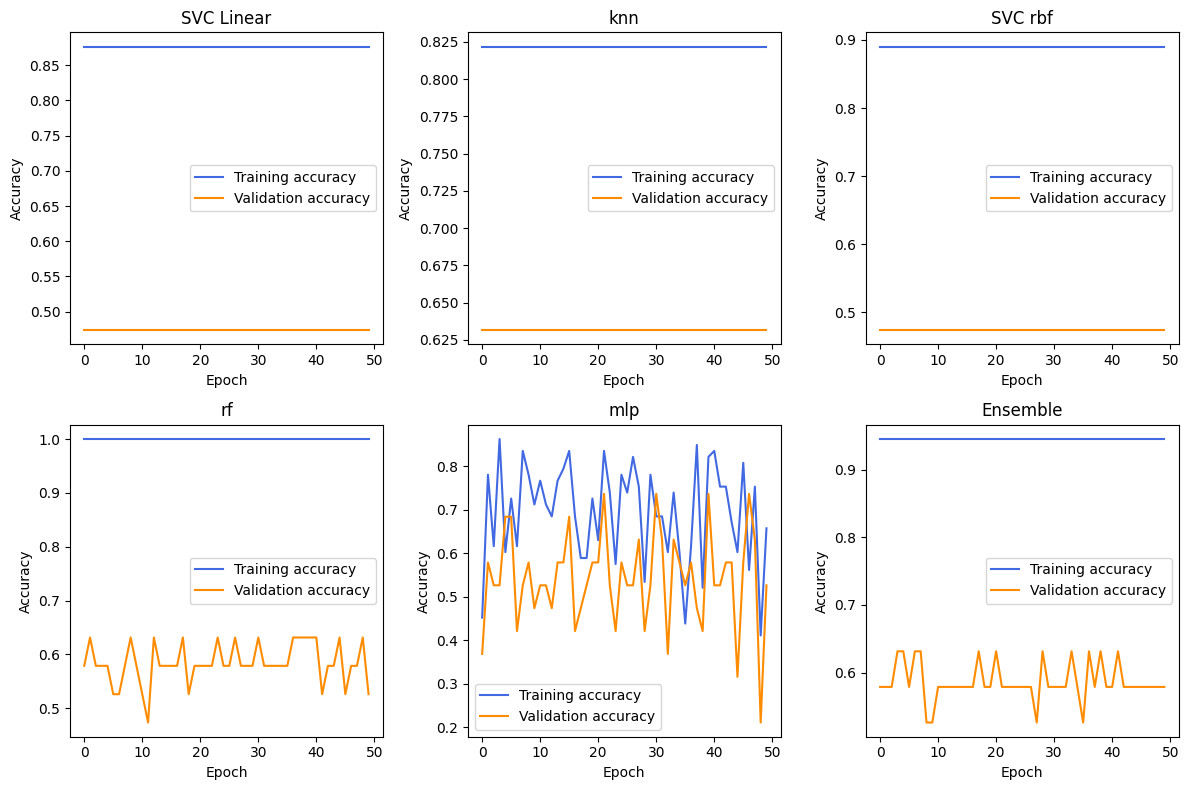

In [ ]:
n = 50

# Define the number of subplots in each row and column
nrows = 2
ncols = 3

# Create a new figure and a grid of subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,8))

# Flatten the axes array to make it easier to iterate over
axes = axes.ravel()

# Define the classifiers
classifiers = [
    (clfs['SVC_linear'], 'SVC Linear'),
    (clfs['KNN'], 'knn'),
    (clfs['SVC_rbf'], 'SVC rbf'),
    (clfs['RF'], 'rf'),
    (clfs['MLP'], 'mlp'),
    (ensemble, 'Ensemble')
]

# Iterate over the classifiers and plot the training and validation scores
for i, (model, model_name) in enumerate(classifiers):
    # Fit the model and record the training and validation scores
    train_scores = []
    val_scores = []
    for j in range(n):
        model.fit(x4_train, y_train)
        train_scores.append(model.score(x4_train, y_train))
        val_scores.append(model.score(x4_val, y_val))
    
    # Select the appropriate subplot and plot the training and validation scores
    ax = axes[i]
    ax.plot(train_scores, color='royalblue', label='Training accuracy')
    ax.plot(val_scores, color='darkorange', label='Validation accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title(model_name)
    ax.legend()

# Adjust the layout of the subplots and show the figure
plt.tight_layout()
plt.show()

Mean train score SVC Linear : 0.8767123287671234
Mean validation score SVC Linear : 0.47368421052631576
Mean train score knn : 0.8219178082191779
Mean validation score knn : 0.6315789473684211
Mean train score SVC rbf : 0.8904109589041096
Mean validation score SVC rbf : 0.47368421052631576
Mean train score rf : 1.0
Mean validation score rf : 0.5873684210526315
Mean train score mlp : 0.7241095890410959
Mean validation score mlp : 0.5778947368421052
Mean train score Ensemble : 0.9452054794520548
Mean validation score Ensemble : 0.5842105263157894


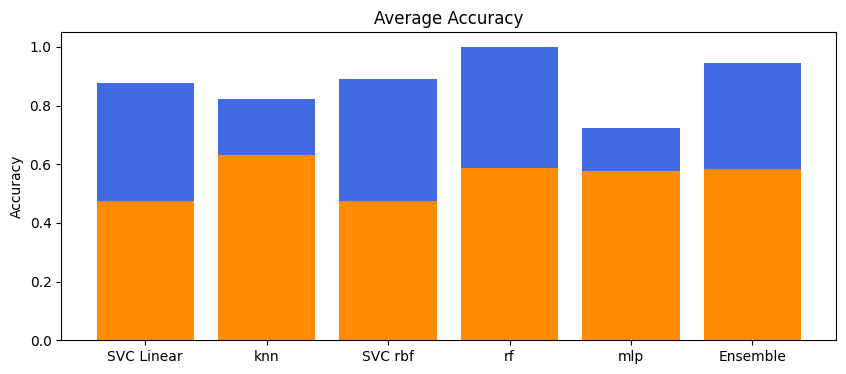

In [ ]:
# Define classifiers and their names
classifiers = [
    (clfs['SVC_linear'], 'SVC Linear'),
    (clfs['KNN'], 'knn'),
    (clfs['SVC_rbf'], 'SVC rbf'),
    (clfs['RF'], 'rf'),
    (clfs['MLP'], 'mlp'),
    (ensemble, 'Ensemble')
]
# Initialize dictionary to store train and validation scores for each classifier
scores = {'train': {}, 'val': {}}

# Calculate train and validation scores for each classifier
for clf, name in classifiers:
    train_scores = []
    val_scores = []
    for j in range(n):
        clf.fit(x4_train, y_train)
        train_scores.append(clf.score(x4_train, y_train))
        val_scores.append(clf.score(x4_val, y_val))
    scores['train'][name] = train_scores
    scores['val'][name] = val_scores

# Calculate and print mean scores for each classifier
for clf, name in classifiers:
    print("Mean train score", name, ":", np.mean(scores['train'][name]))
    print("Mean validation score", name, ":", np.mean(scores['val'][name]))

# Plot mean scores for each classifier
fig, ax = plt.subplots(1, figsize=(10, 4))
for i, (clf, name) in enumerate(classifiers):
    ax.bar(name, np.mean(scores['train'][name]), color='royalblue', label='Training accuracy')
    ax.bar(name, np.mean(scores['val'][name]), color='darkorange', label='Validation accuracy')
ax.set_ylabel('Accuracy')
ax.set_title('Average Accuracy')
plt.show()

# Determine metrics on the test set

Calculate the accuracy on the test set.

In [ ]:
classifiers = [
    (clfs['SVC_linear'], 'SVC Linear'),
    (clfs['KNN'], 'knn'),
    (clfs['SVC_rbf'], 'SVC rbf'),
    (clfs['RF'], 'rf'),
    (clfs['MLP'], 'mlp'),
    (ensemble, 'Ensemble')
]

for clf, name in classifiers:
    y_pred = clf.predict(x4_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy {name}: {accuracy*100:.2f}%")

Accuracy SVC Linear: 60.87%
Accuracy knn: 56.52%
Accuracy SVC rbf: 56.52%
Accuracy rf: 73.91%
Accuracy mlp: 47.83%
Accuracy Ensemble: 69.57%


Determine AUC, specificty and sensitivity on test set


In [ ]:
# Calculate metrics 
classifiers = [
    ('SVC_linear', clfs['SVC_linear']),
    ('KNN', clfs['KNN']),
    ('SVC_rbf', clfs['SVC_rbf']),
    ('RF', clfs['RF']),
    ('MLP', clfs['MLP']),
    ('Ensemble', ensemble)
]

def calculate_metrics(y_test, y_pred):
    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred)
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Calculate specificity
    specificity = tn / (tn + fp)
    # Calculate sensitivity
    sensitivity = tp / (tp + fn)
    return auc, specificity, sensitivity

for name, clf in classifiers:
    y_pred_test = clf.predict(x4_test)
    auc, specificity, sensitivity = calculate_metrics(y_test, y_pred_test)
    print(f'{name} metrics: AUC={auc:.3f}, specificity={specificity:.3f}, sensitivity={sensitivity:.3f}')

SVC_linear metrics: AUC=0.606, specificity=0.545, sensitivity=0.667
KNN metrics: AUC=0.561, specificity=0.455, sensitivity=0.667
SVC_rbf metrics: AUC=0.564, specificity=0.545, sensitivity=0.583
RF metrics: AUC=0.739, specificity=0.727, sensitivity=0.750
MLP metrics: AUC=0.470, specificity=0.273, sensitivity=0.667
Ensemble metrics: AUC=0.697, specificity=0.727, sensitivity=0.667
